# 1-3 転移学習の実装
ここでは次のような流れで PyTorch のチュートリアルに従って画像分類モデルを作成する．
1. 画像データから Dataset を作成する
1. Dataset から DataLoader を作成
1. 任意の出力ができるよう学習済みモデルの出力層を変形
1. 出力層の結合パラメータのみを学習させて転移学習を実装  

## 転移学習
学習済みモデルをベースに最後の出力層を付け替える学習手法を転移学習（transfer learning）と呼ぶ．
自前のデータに合わせて付け替えた出力層のみを学習し直す．
転移学習では少量のデータで性能の良いディープラーニングを実現しやすい．
ちなみに，入力層の近くまでパラメータを更新する場合は fine tuning と呼ばれ，1.5節で扱う．  

## フォルダの準備
make_folders_and_data_downloads.ipynb を実行する．data/hymenoptera_data だ転移学習に使用するデータ．

## 事前準備
for ループの経過時間と残り時間を計測する tqdm をインストールしておく．
```bash
$ pip install tpdm
```  

## 実装の初期設定
パッケージのインポートと乱数のシードを設定する．

In [1]:
%matplotlib inline

import glob
import json
import random
import numpy as np
import os.path as osp
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
# GPU が使えているかの確認
x = torch.randn(10)

# GPU へ送る
x = x.to("cuda")
print(x.is_cuda) # True

# CPU に戻す
x = x.to('cpu')
print(x.is_cuda)  # False

# GPU の番号を指定して送る
x = x.to("cuda:0")
print(x.is_cuda) # True

True
False
True


In [2]:
# GPU で計算するときに結果に再現性を持たせるには，次の設定が必要
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset の作成
次のように3ステップで Dataset を作成する．
1. 画像の前処理を行う ImageTransform クラスの作成
1. ファイルパスをリスト型変数に変換する make_data_list を作成
1. 以上をまとめて HynopteraDataset クラスを作成

訓練時には Data Augmentation（RandomResizedCrop，RandomHorizontalFlip）を行う．
RandomResizedCrop は0.5から1.0の大きさで画像を拡大縮小し，アスペクト比を3/4または4/3の間で変更して画像を引き伸ばした後，指定した大きさに切り出す．
RandomHorizontalFlip では50％の確率で画像の左右を反転させる．

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

class ImageTransform():
    """
    Attributes
    ----------
    resize: int
        リサイズ後の画像の大きさ
    mean: (R,G,B)
        各色チャネルの平均値
    std: (R, G, B)
        各色チャネルの標準偏差
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase="train"):
        """
        Parameters
        ----------
        phase: "train" or "val"
            前処理のモードを選択
        """
        return self.data_transform[phase](img)

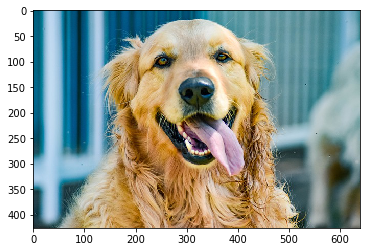

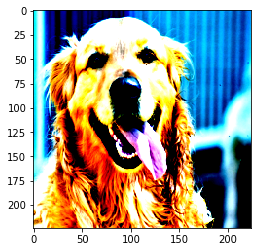

In [11]:
# 訓練時の前処理の動作確認

# 画像の読み込み
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path)

# 元の画像を表示
plt.imshow(img)
plt.show()

# 画像の前処理をして表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

次にデータへのファイルパスを格納したリスト型変数を作成する．
訓練データ243枚と検証データ153枚のそれぞれについて，対応したファイルパスのリストを作成する．

In [17]:
def make_datapath_list(phase="train"):
    """
    Parameters
    ----------
    phase: "train" or "val"
        訓練データか検証データかを指定する
        
    Returns
    -------
    path_list: list
        データへのパスを格納したリスト
    """
    
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + "/**/*.jpg")
    print(target_path)
    
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


最後に Dataset のクラスを作成し訓練データと検証データについてそれぞれのインスタンスを作成．
ラベルとしてアリに0をハチに1を割り当てる．

In [23]:
class HymenopteraDataset(data.Dataset):
    """
    PyTorch の Dataset クラスを継承する
    
    Attributes
    ----------
    file_list: list
        画像のパスを格納したリスト
    transform: object
        前処理クラスのインスタンス
    phase: "train" or "val"
        学習か訓練かを設定する
    """
    
    def __init__(self, file_list, transform, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        # 画像の枚数を返す
        return len(self.file_list)
    
    def __getitem__(self, index):
        # 前処理した画像の Tensor 形式のデータとラベルを取得
        # index 番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        # 画像の前処理
        img_transformed = self.transform(img, self.phase)
        
        # 画像のラベルをファイルパスから取得
        if self.phase == "train":
            label = img_path[30:34]
        if self.phase == "val":
            label = img_path[28:32]
            
        #　ラベルを数値に変換
        if label == "ants":
            label = 0
        if label == "bees":
            label = 1
        
        return img_transformed, label
    
# 実行
train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase="train")
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase="val")

# 動作確認
index = 199
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


## DataLoader を作成
Dataset を使用して torch.utils.data.DataLoader クラスを流用することで DataLoder を作成する．
訓練時にはオプションを指定して画像を取り出す順番がランダムになるようにする．
訓練・検証時に扱いやすいよう，訓練用と検証用の DataLoader をそれぞれ作成し辞書型変数 dataloaders_dict に格納する．

In [26]:
# ミニバッチサイズの指定
batch_size = 32

# DataLoader を作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1])


## ネットワークモデルを生成